# Fruits 360 Data
### Notebook : Fruits-360 - Transfer Learning using Keras from IS
https://www.kaggle.com/amadeus1996/fruits-360-transfer-learning-using-keras

In [1]:
import os
from os import listdir, makedirs
from os.path import join, exists, expanduser

import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

import tensorflow as tf
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import matplotlib.pyplot as plt

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


### Transfer Learning
: 전이학습

학습 데이터가 부족한 경우 다른 분야의 풍부한 데이터로 훈련된 모델을 사용하는 것.  
데이터 부족 문제를 해결할 수 있다는 장점이 있다. 

ex)  
사과 깎는 방법을 익힌 AI에게 배를 깎게 시킨다.  
체스를 익힌 AI에게 비를 예측하게 한다.  
비를 예측하는 AI에게 눈을 예측하게 한다.  

참고 사이트  
https://blog.lgcns.com/1563

Keras의 pretrained model을 사용한다. 

In [19]:
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
    
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)
    
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
!cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/

print("Available Pretrained Models:\n")
!ls ~/.keras/models

Available Pretrained Models:

imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


Read the data

In [3]:
img_width, img_height = 224, 224 # The input size for ResNet-50 is 224 by 224 by 3.

train_data_dir = '../input/fruits/fruits-360/Training'
test_data_dir = '../input/fruits/fruits-360/Test'
batch_size = 16

In [4]:
train_datagen = ImageDataGenerator(rescale = 1. / 255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale=1. / 255) # generate batches of tensor image data with real-time data augmentation

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size = (img_height, img_width), batch_size = batch_size, class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size = (img_height, img_width), batch_size = batch_size, class_mode = 'categorical')
# 90483 images of 131 fruits and vegetables. 103 images are multi fruits set. 

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


Visualize the data

In [5]:
init_notebook_mode(connected = True) # for iplot(fig);

In [6]:
# convert array to dataframe
training_data = pd.DataFrame(train_generator.classes, columns = ['classes'])
testing_data = pd.DataFrame(test_generator.classes, columns = ['classes'])

In [7]:
train_generator.classes # target value

array([  0,   0,   0, ..., 130, 130, 130], dtype=int32)

In [8]:
training_data.tail()

,classes
67687,130
67688,130
67689,130
67690,130
67691,130


In [9]:
def create_stack_bar_data(col, df):
    aggregated = df[col].value_counts().sort_index() # counts per 131 classes
    x_values = aggregated.index.tolist() # 131 classes list : [0, 1, 2 ~ 128, 129, 130]
    y_values = aggregated.values.tolist() # counts per class
    return x_values, y_values

x1, y1 = create_stack_bar_data('classes', training_data)

In [10]:
train_generator.class_indices

{'Apple Braeburn': 0,
 'Apple Crimson Snow': 1,
 'Apple Golden 1': 2,
 'Apple Golden 2': 3,
 'Apple Golden 3': 4,
 'Apple Granny Smith': 5,
 'Apple Pink Lady': 6,
 'Apple Red 1': 7,
 'Apple Red 2': 8,
 'Apple Red 3': 9,
 'Apple Red Delicious': 10,
 'Apple Red Yellow 1': 11,
 'Apple Red Yellow 2': 12,
 'Apricot': 13,
 'Avocado': 14,
 'Avocado ripe': 15,
 'Banana': 16,
 'Banana Lady Finger': 17,
 'Banana Red': 18,
 'Beetroot': 19,
 'Blueberry': 20,
 'Cactus fruit': 21,
 'Cantaloupe 1': 22,
 'Cantaloupe 2': 23,
 'Carambula': 24,
 'Cauliflower': 25,
 'Cherry 1': 26,
 'Cherry 2': 27,
 'Cherry Rainier': 28,
 'Cherry Wax Black': 29,
 'Cherry Wax Red': 30,
 'Cherry Wax Yellow': 31,
 'Chestnut': 32,
 'Clementine': 33,
 'Cocos': 34,
 'Corn': 35,
 'Corn Husk': 36,
 'Cucumber Ripe': 37,
 'Cucumber Ripe 2': 38,
 'Dates': 39,
 'Eggplant': 40,
 'Fig': 41,
 'Ginger Root': 42,
 'Granadilla': 43,
 'Grape Blue': 44,
 'Grape Pink': 45,
 'Grape White': 46,
 'Grape White 2': 47,
 'Grape White 3': 48,
 'Grap

In [11]:
x2 = list(train_generator.class_indices.keys())

In [12]:
trace1 = go.Bar(x = x2, y = y1, opacity = 0.75, name = "Class Count")
layout = dict(height = 400, width = 1400, title = 'Class Distribution in Training Data', legend = dict(orientation = "h"), yaxis = dict(title = 'Class Count'))
fig = go.Figure(data = [trace1], layout = layout);
iplot(fig);

![newplot (12)](https://user-images.githubusercontent.com/53161476/103164028-5d4be700-4849-11eb-8d4f-af116a9bdcae.png)

In [13]:
x1, y1 = create_stack_bar_data('classes', testing_data)
x2 = list(test_generator.class_indices.keys())

trace1 = go.Bar(x = x2, y = y1, opacity = 0.75, name = "Class Count")
layout = dict(height = 400, width = 1400, title = 'Class Distribution in Test Data', legend = dict(orientation = "h"), yaxis = dict(title = 'Class Count'))
fig = go.Figure(data = [trace1], layout = layout);
iplot(fig);

![newplot (13)](https://user-images.githubusercontent.com/53161476/103164036-748ad480-4849-11eb-8032-f0e15861481e.png)

train과 test 둘 다 well-balanced data다. 

Build the model : Pretrained and Vanilla  

참고 사이트  
https://rarena.tistory.com/entry/keras-특정-모델로드하여-내-레이어

In [14]:
# ImageNet 가중치 사용, 상단층 제거. convolution layer만 가져온다. 내가 추가로 fully connected layer를 쌓는다. 
inception_base = applications.ResNet50(weights = 'imagenet', include_top = False) 

# add a global spatial average pooling layer
x = inception_base.output
x = GlobalAveragePooling2D()(x)

# add a fully-connected layer
x = Dense(512, activation = 'relu')(x)

# and a fully connected output/classification layer
predictions = Dense(131, activation ='softmax')(x)

# create the full network so we can train on it
inception_transfer = Model(inputs = inception_base.input, outputs = predictions)

In [20]:
inception_transfer.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [15]:
# 가중치는 임의의 초기값 설정
inception_base_vanilla = applications.ResNet50(weights = None, include_top = False)

x = inception_base_vanilla.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation = 'relu')(x)
predictions = Dense(131, activation = 'softmax')(x)

inception_transfer_vanilla = Model(inputs = inception_base_vanilla.input, outputs=predictions)

In [21]:
inception_transfer_vanilla.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Compile the model

In [16]:
inception_transfer.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr = 1e-4, momentum = 0.9), metrics = ['accuracy'])

inception_transfer_vanilla.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr = 1e-4, momentum = 0.9), metrics = ['accuracy'])

In [17]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10506578754839788719
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15675123303
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1084530515892099563
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


Train and validate the model : Pretrained and Vanilla

In [18]:
with tf.device("/device:GPU:0"):
    history_pretrained = inception_transfer.fit_generator(train_generator, epochs = 5, shuffle = True, verbose = 1, validation_data = test_generator) # ImageDataGenerator로 데이터 객체를 사용하므로 fir_generator()를 사용한다. 

Epoch 1/5
4231/4231 [==============================] - 1508s 356ms/step - loss: 1.2344 - acc: 0.7895 - val_loss: 0.1246 - val_acc: 0.9749
Epoch 2/5
4231/4231 [==============================] - 1177s 278ms/step - loss: 0.0822 - acc: 0.9918 - val_loss: 0.0652 - val_acc: 0.9855
Epoch 3/5
4231/4231 [==============================] - 1182s 279ms/step - loss: 0.0372 - acc: 0.9969 - val_loss: 0.0529 - val_acc: 0.9884
Epoch 4/5
4231/4231 [==============================] - 1180s 279ms/step - loss: 0.0240 - acc: 0.9979 - val_loss: 0.0446 - val_acc: 0.9897
Epoch 5/5
4231/4231 [==============================] - 1181s 279ms/step - loss: 0.0173 - acc: 0.9986 - val_loss: 0.0468 - val_acc: 0.9889


In [22]:
with tf.device("/device:GPU:0"):
    history_vanilla = inception_transfer_vanilla.fit_generator(train_generator, epochs = 5, shuffle = True, verbose = 1, validation_data = test_generator)

Epoch 1/5
4231/4231 [==============================] - 1200s 284ms/step - loss: 2.8889 - acc: 0.3153 - val_loss: 0.8391 - val_acc: 0.8015
Epoch 2/5
4231/4231 [==============================] - 1183s 280ms/step - loss: 0.8758 - acc: 0.7606 - val_loss: 0.3341 - val_acc: 0.9048
Epoch 3/5
4231/4231 [==============================] - 1176s 278ms/step - loss: 0.4164 - acc: 0.8884 - val_loss: 0.2426 - val_acc: 0.9293
Epoch 4/5
4231/4231 [==============================] - 1176s 278ms/step - loss: 0.2431 - acc: 0.9372 - val_loss: 0.1490 - val_acc: 0.9587
Epoch 5/5
4231/4231 [==============================] - 1175s 278ms/step - loss: 0.1637 - acc: 0.9583 - val_loss: 0.1161 - val_acc: 0.9684


Comparison between pretrained and vanilla

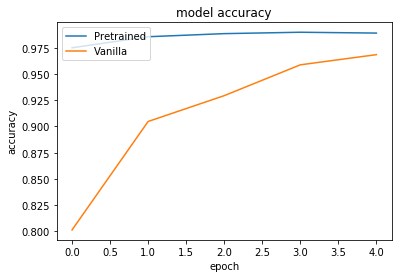

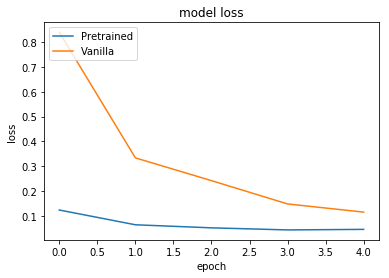

In [23]:
# summarize history for accuracy
plt.plot(history_pretrained.history['val_acc'])
plt.plot(history_vanilla.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Pretrained', 'Vanilla'], loc = 'upper left')
plt.show()

# summarize history for loss
plt.plot(history_pretrained.history['val_loss'])
plt.plot(history_vanilla.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Pretrained', 'Vanilla'], loc = 'upper left')
plt.show()